<a href="https://colab.research.google.com/github/chaitsugale/Cancer_Detection_CNN/blob/main/chaitanya_ugale_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Assinment for Melanoma Detection

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Step 1 : Loading Package and Importing Files
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive

#mounting content from google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
#unzipping the file

#!unzip gdrive/MyDrive/CNN_assignment

!unzip gdrive/MyDrive/CNN_assignment -d '/content/gdrive/MyDrive/'

Archive:  gdrive/MyDrive/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actini

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
cancer_detection_train = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

cancer_detection_test = pathlib.Path('/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [6]:
# checking the list

!ls

gdrive	sample_data


In [7]:
# checking the image count for train and test

image_count_train = len(list(cancer_detection_train.glob('*/*.jpg')))
image_count_test = len(list(cancer_detection_test.glob('*/*.jpg')))

# printing the count
print('No. of image in Train : ',image_count_train)
print('No. of image in Test : ',image_count_test)

No. of image in Train :  2239
No. of image in Test :  118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Step 2 : Creating Dataset

Define some parameters for the loader:

In [8]:
# Defining some parameter for the loader

batch_size = 32
image_height = 180
image_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
cancer_detection_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    cancer_detection_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'training',
    image_size=(image_height,image_width),
    batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
cancer_detection_valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    cancer_detection_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'validation',
    image_size=(image_height,image_width),
    batch_size=batch_size

)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
cancer_class = cancer_detection_train_ds.class_names
print(cancer_class)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Step 3: Dataset Visualization
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

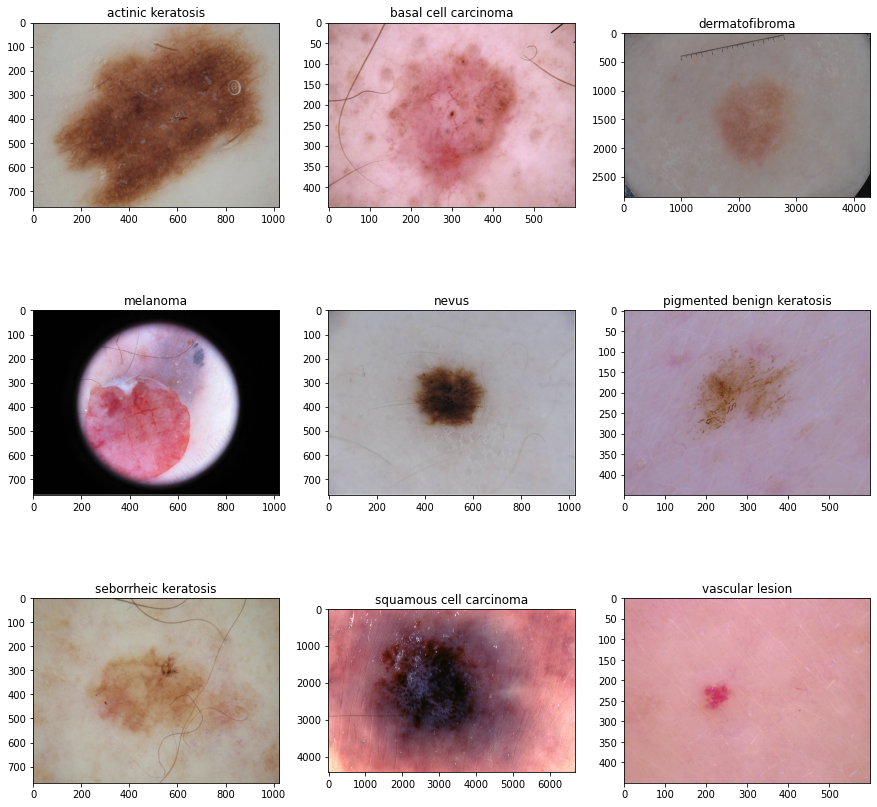

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(15,15))
for i in range(9): 
  plt.subplot(3, 3, i + 1)
  cancer_image = plt.imread(str(list(cancer_detection_test.glob(cancer_class[i]+'/*.jpg'))[1]))
  plt.title(cancer_class[i])
  plt.imshow(cancer_image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
cancer_data_autotune = tf.data.experimental.AUTOTUNE

cancer_detection_train_ds = cancer_detection_train_ds.cache().shuffle(1000).prefetch(buffer_size=cancer_data_autotune)

cancer_detection_valid_ds = cancer_detection_valid_ds.cache().prefetch(buffer_size=cancer_data_autotune)


### Step 4 : Model Building and Training 
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
### Your code goes here

cancer_num_class = 9

cancer_model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(image_height,image_width,3)),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(cancer_num_class)
]
)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
cancer_model.compile(optimizer='adam',
                     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

In [16]:
# View the summary of all layers
cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs = 20

cancer_history = cancer_model.fit(
    cancer_detection_train_ds,
    validation_data = cancer_detection_valid_ds,
    epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 30s 113ms/step - loss: 2.0996 - accuracy: 0.2349 - val_loss: 1.9222 - val_accuracy: 0.2685
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.7587 - accuracy: 0.3744 - val_loss: 1.6084 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 3s 45ms/step - loss: 1.5326 - accuracy: 0.4721 - val_loss: 1.5576 - val_accuracy: 0.4318
Epoch 4/20
56/56 [==============================] - 3s 45ms/step - loss: 1.4067 - accuracy: 0.5106 - val_loss: 1.3934 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 3s 45ms/step - loss: 1.3477 - accuracy: 0.5329 - val_loss: 1.5060 - val_accuracy: 0.4564
Epoch 6/20
56/56 [==============================] - 3s 45ms/step - loss: 1.2798 - accuracy: 0.5485 - val_loss: 1.4544 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 3s 45ms/step - loss: 1.1968 - accuracy: 0.5804 - val_loss: 1.3991 - val_accuracy: 0.5101
Epoch 8/20


### Visualizing training results



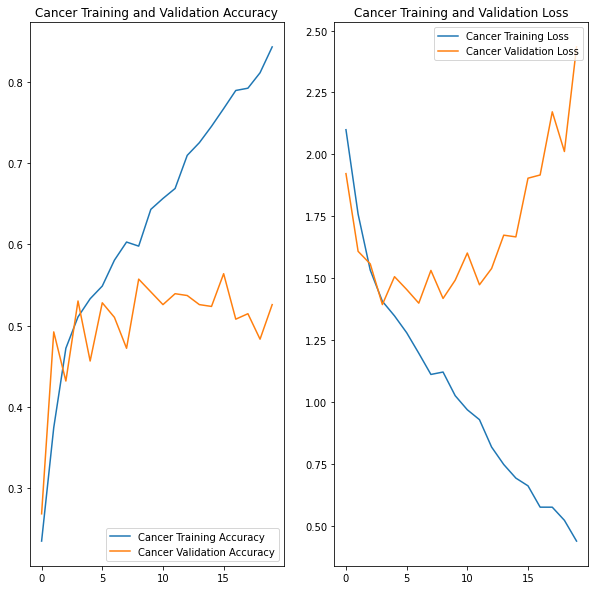

In [18]:
#Declaring Accuracy
cancer_accuracy = cancer_history.history['accuracy']

cancer_valid_accuracy = cancer_history.history['val_accuracy']

#Declaring Loss
cancer_loss = cancer_history.history['loss']

cancer_valid_loss = cancer_history.history['val_loss']

epochs_range = range(epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,cancer_accuracy,label='Cancer Training Accuracy')
plt.plot(epochs_range,cancer_valid_accuracy,label='Cancer Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Cancer Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,cancer_loss,label='Cancer Training Loss')
plt.plot(epochs_range,cancer_valid_loss,label='Cancer Validation Loss')
plt.legend(loc='upper right')
plt.title("Cancer Training and Validation Loss")

plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

**As per Finding on First Base Model**



1.   The Model is **OverFitting** because we can see difference in Loss Function in Training and Testing around the 10th - 15 th Epochs

2.   The Accuracy of this Model is around **80%**

3.   It appears that model is Overfitting  and understanding the difference with later Epochs



### Declaring Data Augmentation

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

cancer_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(image_height, 
                                                              image_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.4,fill_mode = 'reflect'),
    layers.experimental.preprocessing.RandomZoom(height_factor=(0.1, 0.2), width_factor=(0.1, 0.2), fill_mode='constant'),
  ]
)

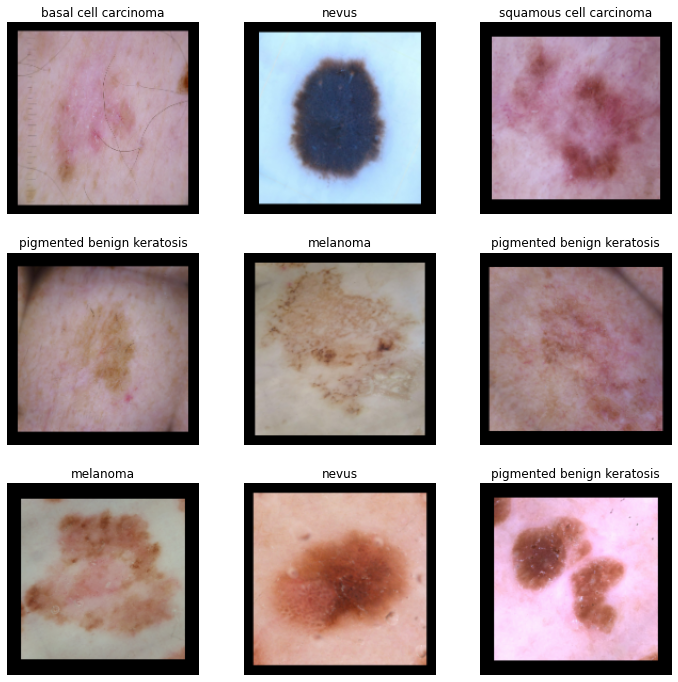

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, labels in cancer_detection_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(cancer_augmentation(images)[i].numpy().astype("uint8"))
        plt.title(cancer_class[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
# creating the model using augmentation

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D


cancer_num_class = 9

cancer_model = Sequential([
    cancer_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3,padding='same',activation='relu'),
    layers.MaxPooling2D(),  
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(cancer_num_class)         
])


### Compiling the model

In [22]:
cancer_model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20

cancer_history = cancer_model.fit(
    cancer_detection_train_ds,
    validation_data=cancer_detection_valid_ds,
    epochs = epochs
)

Epoch 1/20
56/56 [==============================] - 5s 59ms/step - loss: 2.1486 - accuracy: 0.1853 - val_loss: 2.0152 - val_accuracy: 0.2081
Epoch 2/20
56/56 [==============================] - 3s 54ms/step - loss: 1.9484 - accuracy: 0.2612 - val_loss: 1.8435 - val_accuracy: 0.2975
Epoch 3/20
56/56 [==============================] - 3s 53ms/step - loss: 1.7818 - accuracy: 0.3410 - val_loss: 1.8092 - val_accuracy: 0.2819
Epoch 4/20
56/56 [==============================] - 3s 53ms/step - loss: 1.6720 - accuracy: 0.3811 - val_loss: 1.9000 - val_accuracy: 0.3356
Epoch 5/20
56/56 [==============================] - 3s 53ms/step - loss: 1.6609 - accuracy: 0.3945 - val_loss: 1.9198 - val_accuracy: 0.2864
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5799 - accuracy: 0.4386 - val_loss: 1.5859 - val_accuracy: 0.4541
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.4967 - accuracy: 0.4771 - val_loss: 1.6189 - val_accuracy: 0.4228
Epoch 8/20
56

### Visualizing the results

Text(0.5, 1.0, 'Cancer Training and Validation Loss')

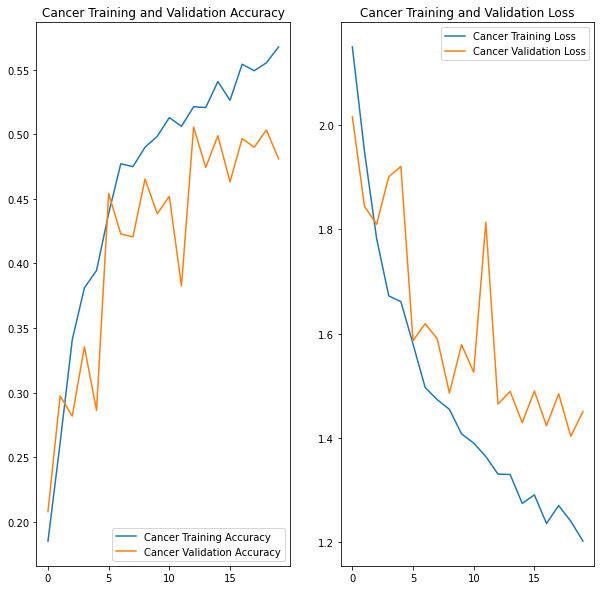

In [24]:
#Declaring Accuracy
cancer_accuracy = cancer_history.history['accuracy']

cancer_valid_accuracy = cancer_history.history['val_accuracy']

#Declaring Loss
cancer_loss = cancer_history.history['loss']

cancer_valid_loss = cancer_history.history['val_loss']

epochs_range = range(epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,cancer_accuracy,label='Cancer Training Accuracy')
plt.plot(epochs_range,cancer_valid_accuracy,label='Cancer Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Cancer Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,cancer_loss,label='Cancer Training Loss')
plt.plot(epochs_range,cancer_valid_loss,label='Cancer Validation Loss')
plt.legend(loc='upper right')
plt.title("Cancer Training and Validation Loss")

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**As per Finding on Second Base Model**



1.   No improvement in Accuracy , on the contrary it is **dropped**

2.   Due to Data Augmentation we can see the Overfitting problem is solved

3.   We can increase the epochs to increase the accuracy so it's too early for judgement

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [36]:
## Your code goes here.

from glob import glob

cancer_path = [x for x in glob(os.path.join(cancer_detection_train,'*','*.jpg'))]

cancer_lension = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(cancer_detection_train,'*','*.jpg'))]

len(cancer_path)

2239

In [37]:
# creating dictionary for cancer dataframe

cancer_dict =dict(zip(cancer_path,cancer_lension))

cancer_dataframe = pd.DataFrame(list(cancer_dict.items()),columns=['Path','Label'])

cancer_dataframe


,Path,Label
0,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
1,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
2,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
3,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
4,/content/gdrive/MyDrive/Skin cancer ISIC The I...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2235,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2236,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion
2237,/content/gdrive/MyDrive/Skin cancer ISIC The I...,vascular lesion


<BarContainer object of 9 artists>

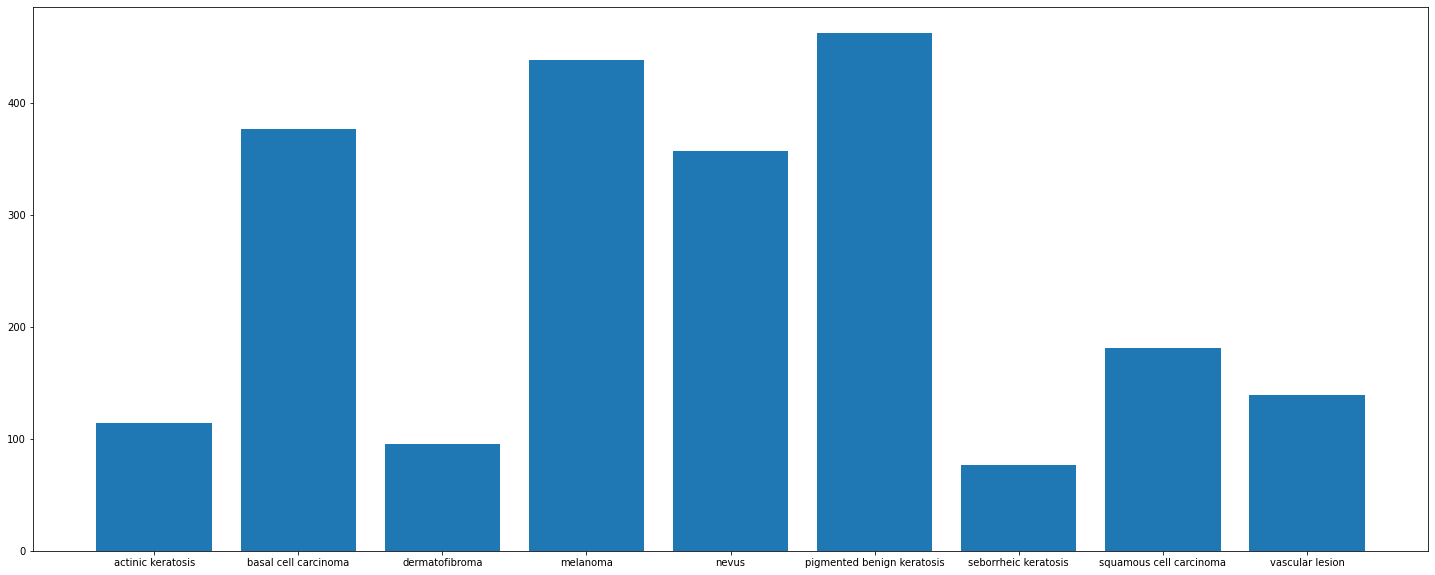

In [38]:
count=[]
for i in cancer_class:
    count.append(len(list(cancer_detection_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(cancer_class,count)

In [43]:
from sklearn.preprocessing import LabelEncoder

from collections import Counter

X,y = cancer_dataframe['Path'],cancer_dataframe['Label']

y = LabelEncoder().fit_transform(y)

counter = Counter(y)

for k,v in counter.items():
  per = v/len(y)*100
  print('Cancer Class = %d , count = %d , count percent = %.3f%%'%(k,v,per))


Cancer Class = 0 , count = 114 , count percent = 5.092%
Cancer Class = 1 , count = 376 , count percent = 16.793%
Cancer Class = 2 , count = 95 , count percent = 4.243%
Cancer Class = 3 , count = 438 , count percent = 19.562%
Cancer Class = 4 , count = 357 , count percent = 15.945%
Cancer Class = 5 , count = 462 , count percent = 20.634%
Cancer Class = 6 , count = 77 , count percent = 3.439%
Cancer Class = 7 , count = 181 , count percent = 8.084%
Cancer Class = 8 , count = 139 , count percent = 6.208%


#### **Todo:** Write your findings here: 
#### Q1 - Which class has the least number of samples?
#### Q2 - Which classes dominate the data in terms proportionate number of samples?


Answer:
 1. Least Number of Sample : seborrheic keratosis

 2. Highest Data : melanoma, nevus, pigmented benign keratosis and basal cell carcinoma


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [39]:
!pip install Augmentor


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
import Augmentor

for i in cancer_class:
    cancer_data_path = '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'+i+'/'
    print(cancer_data_path)
    cancer_pipeline  = Augmentor.Pipeline(cancer_data_path)
    cancer_pipeline.rotate(probability=0.7, max_left_rotation=15, max_right_rotation=15)
    cancer_pipeline.sample(500)## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFD5E8D49D0>: 100%|██████████| 500/500 [00:26<00:00, 18.82 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFD5E92ACD0>: 100%|██████████| 500/500 [00:23<00:00, 21.42 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFD5E91BA90>: 100%|██████████| 500/500 [00:22<00:00, 22.56 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7EFE4F8D7AD0>: 100%|██████████| 500/500 [01:54<00:00,  4.37 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFED56050D0>: 100%|██████████| 500/500 [01:36<00:00,  5.16 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFD5E903590>: 100%|██████████| 500/500 [00:22<00:00, 22.58 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7EFD5EA50790>: 100%|██████████| 500/500 [00:50<00:00,  9.90 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7EFE4F9CAD50>: 100%|██████████| 500/500 [00:21<00:00, 23.17 Samples/s]


/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7EFD5E999E10>: 100%|██████████| 500/500 [00:21<00:00, 23.37 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [46]:
cancer_image_count = len(list(cancer_detection_train.glob('*/output/*.jpg')))
print("No Of Image : ",cancer_image_count)

No Of Image :  4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [48]:
cancer_path_new= [path for path in glob(os.path.join(cancer_detection_train, '*','output', '*.jpg'))]
cancer_path_new

['/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027254.jpg_94888e29-a2dd-4d77-a6bd-be3a0732f9d1.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033811.jpg_6843249a-29a5-4101-a342-3054692cfe06.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027580.jpg_b0f5b1ef-531a-4dfe-844e-1faf70c7309b.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_91636c27-ec87-4ab8-8a7d-8cc645e98717.jpg',
 '/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033494.jpg_9ad8df9f-62a7

In [50]:
cancer_lesion_new = [os.path.basename(os.path.dirname(os.path.dirname(label))) for label in glob(os.path.join(cancer_detection_train, '*','output', '*.jpg'))]
cancer_lesion_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [51]:
dataframe_dict_new = dict(zip(cancer_path_new,cancer_lesion_new ))

In [52]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
cancer_data = cancer_dataframe.append(df2)

In [54]:
cancer_data['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Step 5 : Creating Augmentor Model

#### **Todo**: Train the model on the data created using Augmentor

In [55]:
batch_size = 32
image_height = 180
image_width = 180

#### **Todo:** Create a training dataset

In [56]:
cancer_train_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
    cancer_detection_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'training',
    image_size=(image_height,image_width),
    batch_size=batch_size

)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [57]:
cancer_valid_ds_new = tf.keras.preprocessing.image_dataset_from_directory(
    cancer_detection_train,
    seed = 123,
    validation_split = 0.2,
    subset = 'validation',
    image_size=(image_height,image_width),
    batch_size=batch_size

)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [59]:
# Autotuning the train and valid dataset

cancer_autotune_new = tf.data.experimental.AUTOTUNE

cancer_train_ds_new = cancer_train_ds_new.cache().shuffle(1000).prefetch(buffer_size=cancer_autotune_new)
cancer_valid_ds_new = cancer_valid_ds_new.cache().prefetch(buffer_size=cancer_autotune_new)

# Creating model using augmentor

cancer_model_new = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(cancer_num_class)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [60]:
## your code goes here

cancer_model_new .compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [61]:
epochs = 30

cancer_history_new = cancer_model_new.fit(
  cancer_train_ds_new,
  validation_data=cancer_valid_ds_new,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 45s 94ms/step - loss: 1.8896 - accuracy: 0.2773 - val_loss: 1.5990 - val_accuracy: 0.3920
Epoch 2/30
169/169 [==============================] - 8s 45ms/step - loss: 1.5125 - accuracy: 0.4238 - val_loss: 1.4198 - val_accuracy: 0.4603
Epoch 3/30
169/169 [==============================] - 8s 45ms/step - loss: 1.3279 - accuracy: 0.4983 - val_loss: 1.4156 - val_accuracy: 0.4625
Epoch 4/30
169/169 [==============================] - 8s 45ms/step - loss: 1.1856 - accuracy: 0.5547 - val_loss: 1.1606 - val_accuracy: 0.5843
Epoch 5/30
169/169 [==============================] - 8s 46ms/step - loss: 1.0262 - accuracy: 0.6257 - val_loss: 1.0868 - val_accuracy: 0.6013
Epoch 6/30
169/169 [==============================] - 9s 51ms/step - loss: 0.9253 - accuracy: 0.6591 - val_loss: 1.0797 - val_accuracy: 0.6073
Epoch 7/30
169/169 [==============================] - 8s 48ms/step - loss: 0.7927 - accuracy: 0.7092 - val_loss: 0.9491 - val_accuracy: 0.654

#### **Todo:**  Visualize the model results

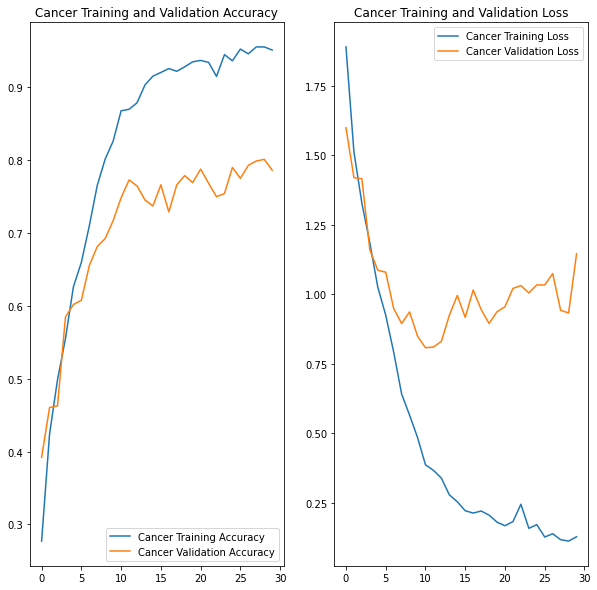

In [63]:
#Declaring Accuracy
cancer_accuracy = cancer_history_new.history['accuracy']

cancer_valid_accuracy = cancer_history_new.history['val_accuracy']

#Declaring Loss
cancer_loss = cancer_history_new.history['loss']

cancer_valid_loss = cancer_history_new.history['val_loss']

epochs_range = range(epochs)

# Plotting Graph for Accuracy and Loss

#Graph for accuracy

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range,cancer_accuracy,label='Cancer Training Accuracy')
plt.plot(epochs_range,cancer_valid_accuracy,label='Cancer Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Cancer Training and Validation Accuracy")

#Graph for Loss

plt.subplot(1,2,2)
plt.plot(epochs_range,cancer_loss,label='Cancer Training Loss')
plt.plot(epochs_range,cancer_valid_loss,label='Cancer Validation Loss')
plt.legend(loc='upper right')
plt.title("Cancer Training and Validation Loss")

plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**As per Finding on  Model created using Augmentor**



1.   After using Augmentor Library the accuracy of Training is increased upto **95%**

2.   Model is still overfitting and it can be solved by adding more layers,neurons or adding dropouts level

3.   The Model can be further improved by tuning the hyperparameter